<a href="https://colab.research.google.com/github/chagai207/Data-mining/blob/main/Project_Chagai_and_Maor_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chagai Englman - 208065839, Maor Levy - 324958008

# 1. Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    validation_curve,
    cross_val_predict,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import loguniform, uniform
import joblib
from sklearn.compose import ColumnTransformer

# 2. Load Data

 Read  the data to df from a csv file

In [ ]:
from google.colab import files
uploaded = files.upload()
uploaded2 = files.upload()

Saving churn_dataset_train.csv to churn_dataset_train.csv


Saving churn_dataset_test.csv to churn_dataset_test.csv


In [ ]:
train_df = pd.read_csv("churn_dataset_train.csv")
test_df = pd.read_csv("churn_dataset_test.csv")

In [ ]:
train_df.head()

,Unnamed: 0,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn
0,1644,fffe43004900440033003200390032003400,Dusty Dunneback,30,F,URPJZ5B,Village,No Membership,09/08/2017,Yes,...,118.390000,10579.56,24,610.360000,Yes,No,No,Not Applicable,Poor Product Quality,1
1,8516,fffe43004900440036003200310038003600,Dorine Vanduyn,55,M,O0IWUYW,Village,Silver Membership,09/02/2016,No,...,179.420000,22963.05,27,694.650000,Yes,No,No,Not Applicable,Poor Product Quality,0
2,15564,fffe430049004400350032003200,Christene Pulver,47,M,2R0EFA2,City,Basic Membership,11/06/2017,Yes,...,42.230000,32604.41,Error,520.620000,Yes,No,No,Not Applicable,Poor Product Quality,1
3,22211,fffe43004900440032003200380034003600,Brendan Enciso,18,M,XF0YGUT,Town,Gold Membership,09/02/2016,No,...,-1035.833706,48913.61,27,1150.093442,Yes,No,No,Not Applicable,Too many ads,0
4,32088,fffe43004900440035003600320032003100,Lizette Lemons,28,F,V5YZC2N,City,No Membership,16/07/2017,Yes,...,449.770000,20010.02,14,653.040000,Yes,Yes,Yes,No Information Available,No reason specified,0


In [ ]:
test_df.head()

,Unnamed: 0,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
0,14132,Faustina Voisine,14,F,CNUZFRS,Town,Silver Membership,04/09/2017,Yes,CID11574,...,6,31.420000,24446.05,8,NaN,Yes,No,No,Not Applicable,No reason specified
1,34651,Necole Goold,17,M,P8Y6WOK,City,Basic Membership,03/08/2016,Yes,CID49063,...,9,-737.469487,24552.10,6,318.054414,No,Yes,Yes,Solved in Follow-up,Poor Website
2,400,Mickey Melody,39,M,18OSPOO,Town,Basic Membership,16/11/2016,No,NaN,...,8,417.990000,37839.02,16,654.799667,No,Yes,No,Not Applicable,No reason specified
3,20818,Maricela Drolet,34,F,EP7F6B4,NaN,No Membership,19/08/2017,NaN,NaN,...,4,218.750000,1813.76,49.17114728,574.650000,Yes,No,No,Not Applicable,Poor Product Quality
4,1384,Alethia Wykoff,48,F,S18UZRG,Town,Basic Membership,25/08/2015,Yes,CID2074,...,7,549.930000,15795.89,12,NaN,Yes,No,Yes,Unsolved,No reason specified


## 3. Apriori algorithem

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Select categorical columns for rule mining
cat_cols = [
    'gender', 'region_category', 'membership_category', 'joined_through_referral',
    'used_special_discount', 'offer_application_preference', 'past_complaint', 'feedback'
]

# Convert each row to a list of item-style features
transactions = train_df[train_df['churn'] == 1][cat_cols].astype(str)\
    .apply(lambda row: [f"{col}={val}" for col, val in row.items()], axis=1).tolist()

# Binary encode the transactions
te = TransactionEncoder()
te_data = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_data, columns=te.columns_)

# Find frequent item combinations
frequent_itemsets = apriori(df_trans, min_support=0.05, use_colnames=True)

# Generate rules with minimum confidence
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Keep rules with 2 or more conditions
rules = rules[rules['antecedents'].apply(lambda x: len(x) >= 2)]

# Show top rules with support, confidence, and lift
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)


,antecedents,consequents,support,confidence,lift
4,"(used_special_discount=Yes, feedback=No reason...",(offer_application_preference=No),0.087029,0.826840,1.804413
5,"(feedback=No reason specified, offer_applicati...",(used_special_discount=Yes),0.087029,1.000000,1.823318
6,"(used_special_discount=No, feedback=No reason ...",(offer_application_preference=Yes),0.094320,1.000000,1.845809
7,"(offer_application_preference=Yes, feedback=No...",(used_special_discount=No),0.094320,0.838057,1.855959
8,"(used_special_discount=Yes, feedback=Poor Cust...",(offer_application_preference=No),0.093256,0.849239,1.853295
9,"(feedback=Poor Customer Service, offer_applica...",(used_special_discount=Yes),0.093256,1.000000,1.823318
10,"(used_special_discount=No, feedback=Poor Custo...",(offer_application_preference=Yes),0.090826,1.000000,1.845809
11,"(offer_application_preference=Yes, feedback=Po...",(used_special_discount=No),0.090826,0.845827,1.873168
12,"(feedback=Poor Product Quality, used_special_d...",(offer_application_preference=No),0.094320,0.839189,1.831363
13,"(feedback=Poor Product Quality, offer_applicat...",(used_special_discount=Yes),0.094320,1.000000,1.823318


### # New binary feature based on Apriori pattern

In [ ]:
# Based on Rule #12:
# If feedback is "Poor Product Quality" and used_special_discount is "Yes"
# Then high chance offer_application_preference is "No"
train_df['pattern_feedback_discount'] = (
    (train_df['feedback'] == 'Poor Product Quality') &
    (train_df['used_special_discount'] == 'Yes')
).astype(int)

test_df['pattern_feedback_discount'] = (
    (test_df['feedback'] == 'Poor Product Quality') &
    (test_df['used_special_discount'] == 'Yes')
).astype(int)


# Based on Rule #4:
# If feedback is "No reason specified" and used_special_discount is "Yes"
# Then high chance offer_application_preference is "No"
train_df['pattern_no_reason_discount'] = (
    (train_df['feedback'] == 'No reason specified') &
    (train_df['used_special_discount'] == 'Yes')
).astype(int)

test_df['pattern_no_reason_discount'] = (
    (test_df['feedback'] == 'No reason specified') &
    (test_df['used_special_discount'] == 'Yes')
).astype(int)


# Based on Rule #8:
# If feedback is "Poor Customer Service" and used_special_discount is "Yes"
# Then high chance offer_application_preference is "No"
train_df['pattern_bad_service_discount'] = (
    (train_df['feedback'] == 'Poor Customer Service') &
    (train_df['used_special_discount'] == 'Yes')
).astype(int)

test_df['pattern_bad_service_discount'] = (
    (test_df['feedback'] == 'Poor Customer Service') &
    (test_df['used_special_discount'] == 'Yes')
).astype(int)


# 3. Preprocessing

In [ ]:
# Function to fill missing values based on the existing distribution of the column
def fill_missing_by_distribution(df, column_name):
    mask = df[column_name].isna()
    choices = df[column_name].dropna()

    df.loc[mask, column_name] = np.random.choice(
        choices.unique(),
        size=mask.sum(),
        p=choices.value_counts(normalize=True).reindex(choices.unique()).values
    )
    return df
# One-hot encode specified categorical columns
def one_hot_encode_columns(df, columns):
    # Converts categorical variables into dummy/indicator variables
    return pd.get_dummies(df, columns=columns, drop_first=True)

# Map binary Yes/No columns to 1/0
def map_yes_no_binary(df, columns):
    # Assumes columns contain only 'Yes' or 'No' values
    mapping = {'Yes': 1, 'No': 0}
    for col in columns:
        df[col] = df[col].map(mapping)
    return df

# Normalize numerical columns to the [0, 1] range
def normalize_columns(df, columns):
    # Applies Min-Max scaling: (x - min) / (max - min)
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

# Define preprocessing function to apply to both train and test
def preprocess_df(df, is_train=True):
    if is_train:
        target = pd.DataFrame(df['churn'])

    # Drop irrelevant ID columns
    df = df.drop(['customer_id', 'security_no', 'referral_id', 'Name'], axis=1, errors='ignore')

    # Clean and convert avg_frequency_login_days
    df['avg_frequency_login_days'] = df['avg_frequency_login_days'].replace(['Error'], pd.NA)
    df['avg_frequency_login_days'] = pd.to_numeric(df['avg_frequency_login_days'], errors='coerce').abs()

    # Extract date parts from joining_date
    df['joining_date'] = pd.to_datetime(df['joining_date'], errors='coerce', dayfirst=True)
    df['join_year'] = df['joining_date'].dt.year
    df['join_month'] = df['joining_date'].dt.month
    df['join_day'] = df['joining_date'].dt.day
    df = df.drop(columns=['joining_date'])

    # Fix negatives in login
    df.loc[df['days_since_last_login'] < 0, 'days_since_last_login'] = np.nan

    # Fill missing categorical values using distribution
    for col in ['region_category', 'joined_through_referral', 'preferred_offer_types',
                'medium_of_operation', 'avg_frequency_login_days',
                'days_since_last_login', 'internet_option']:
        df = fill_missing_by_distribution(df, col)

    # One-hot encode selected categorical columns
    cat_columns = ['region_category', 'preferred_offer_types', 'medium_of_operation', 'internet_option']
    df = one_hot_encode_columns(df, cat_columns)

    # Clean and process 'gender' separately
    df['gender'] = df['gender'].replace('Unknown', pd.NA)
    df = fill_missing_by_distribution(df, 'gender')
    df['gender'] = df['gender'].map({'M': 0, 'F': 1})

    # Encode membership
    membership_mapping = {
        'No Membership': 0,
        'Basic Membership': 1,
        'Silver Membership': 2,
        'Gold Membership': 3,
        'Platinum Membership': 4,
        'Premium Membership': 5
    }
    df['membership_category'] = df['membership_category'].map(membership_mapping)

    # Handle points_in_wallet with Gaussian sampling, then standardize
    df['points_in_wallet'] = pd.to_numeric(df['points_in_wallet'], errors='coerce')
    df['points_in_wallet'] = df['points_in_wallet'].abs()
    mean_val = df['points_in_wallet'].mean()
    std_val = df['points_in_wallet'].std()
    nan_count = df['points_in_wallet'].isna().sum()
    sampled_vals = np.random.normal(loc=mean_val, scale=std_val, size=nan_count)
    df.loc[df['points_in_wallet'].isna(), 'points_in_wallet'] = sampled_vals
    df['points_in_wallet_zscore'] = (df['points_in_wallet'] - mean_val) / std_val
    df.drop(columns='points_in_wallet', inplace=True)

    # Replace negative values in avg_time_spent with mode
    mode_val = df['avg_time_spent'].mode()[0]
    df.loc[df['avg_time_spent'] < 0, 'avg_time_spent'] = mode_val

    # Handle complaint_status and one-hot encode
    df['complaint_status'] = df['complaint_status'].replace({
        'Not Applicable': 'No Complain',
        'No Information Available': 'Unknown'
    })
    df = pd.get_dummies(df, columns=['complaint_status'], prefix='complaint', dtype = int)

    # Age groups
    df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 50, 100], labels=['Young', 'Adult', 'Mature', 'Senior'])
    df = pd.get_dummies(df, columns=['age_group'], drop_first=False, dtype = int)

    # Feedback sentiment mapping
    pos_feedback = ["Products always in Stock", "Reasonable Price", "User Friendly Website", "Quality Customer Care"]
    neg_feedback = ["Poor Product Quality", "Too many ads", "Poor Customer Service", "Poor Website"]

    def categorize_feedback(fb):
        if fb in pos_feedback: return 1
        elif fb in neg_feedback: return 0
        else: return 'Unknown'

    df['Is_feedback_positive'] = df['feedback'].apply(categorize_feedback)
    df.drop('feedback', axis=1, inplace=True)

    valid = df['Is_feedback_positive'].value_counts()
    valid = valid[valid.index.isin([0, 1])]
    if not valid.empty:
        probs = valid / valid.sum()
        unknown_idx = df[df['Is_feedback_positive'] == 'Unknown'].index
        sampled = np.random.choice(probs.index, size=len(unknown_idx), p=probs.values)
        df.loc[unknown_idx, 'Is_feedback_positive'] = sampled
        df['Is_feedback_positive'] = df['Is_feedback_positive'].astype(int)

    # Map Yes/No to 1/0
    df = map_yes_no_binary(df, ['used_special_discount', 'offer_application_preference',
                                'past_complaint', 'joined_through_referral'])

    # Normalize selected numeric columns (last step)
    cols_to_normalize = ['days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days']
    df = normalize_columns(df, cols_to_normalize)

    return (df, target) if is_train else df

# Apply preprocessing to train and test sets
train_df, train_target = preprocess_df(train_df, is_train=True)
test_df = preprocess_df(test_df, is_train=False)

In [ ]:
train_df.head()

,Unnamed: 0,age,gender,membership_category,joined_through_referral,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,used_special_discount,...,complaint_No Complain,complaint_Solved,complaint_Solved in Follow-up,complaint_Unknown,complaint_Unsolved,age_group_Young,age_group_Adult,age_group_Mature,age_group_Senior,Is_feedback_positive
0,1644,30,1,0,1,0.76,0.034137,0.098666,0.357816,1,...,1,0,0,0,0,0,1,0,0,0
1,8516,55,0,2,0,0.56,0.054310,0.223608,0.402555,1,...,1,0,0,0,0,0,0,0,1,0
2,15564,47,0,1,1,0.88,0.008963,0.320884,0.149036,1,...,1,0,0,0,0,0,0,1,0,0
3,22211,18,0,3,0,0.24,0.006275,0.485434,0.402555,1,...,1,0,0,0,0,1,0,0,0,0
4,32088,28,1,0,1,0.36,0.143674,0.193814,0.208687,1,...,0,0,0,1,0,0,1,0,0,1


In [ ]:
test_df.head()

,Unnamed: 0,age,gender,membership_category,joined_through_referral,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,used_special_discount,...,complaint_No Complain,complaint_Solved,complaint_Solved in Follow-up,complaint_Unknown,complaint_Unsolved,age_group_Young,age_group_Adult,age_group_Mature,age_group_Senior,Is_feedback_positive
0,14132,14,1,2,1,0.20,0.009148,0.238954,0.109125,1,...,1,0,0,0,0,1,0,0,0,0
1,34651,17,0,1,1,0.32,0.010048,0.240026,0.081739,0,...,0,0,1,0,0,1,0,0,0,0
2,400,39,0,1,0,0.28,0.128691,0.374321,0.218666,0,...,1,0,0,0,0,0,0,1,0,0
3,20818,34,1,0,0,0.12,0.067078,0.010203,0.672869,1,...,1,0,0,0,0,0,1,0,0,0
4,1384,48,1,1,1,0.24,0.169492,0.151524,0.163896,1,...,0,0,0,0,1,0,0,1,0,0


# 4. Export data

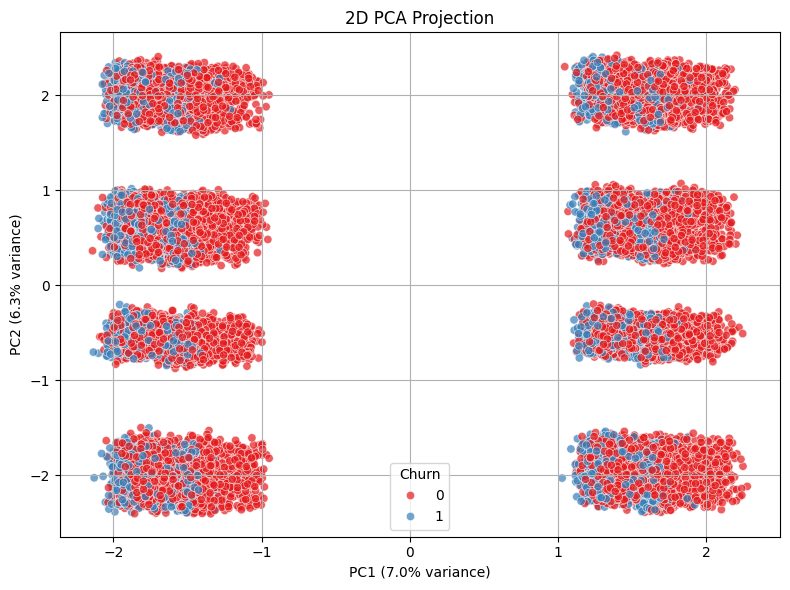

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Separate features and target from train_df
X = train_df.drop(columns=['churn'])
y = train_df['churn']

# Step 2: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA (2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Build DataFrame with PCA results and target
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'churn': y
})

# Step 5: Plot PCA result
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='churn',
    palette='Set1',
    alpha=0.7
)

explained_var = pca.explained_variance_ratio_ * 100
plt.xlabel(f'PC1 ({explained_var[0]:.1f}% variance)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f}% variance)')
plt.title('2D PCA Projection')
plt.grid(True)
plt.legend(title='Churn')
plt.tight_layout()
plt.show()


## 5. Imbalanced data

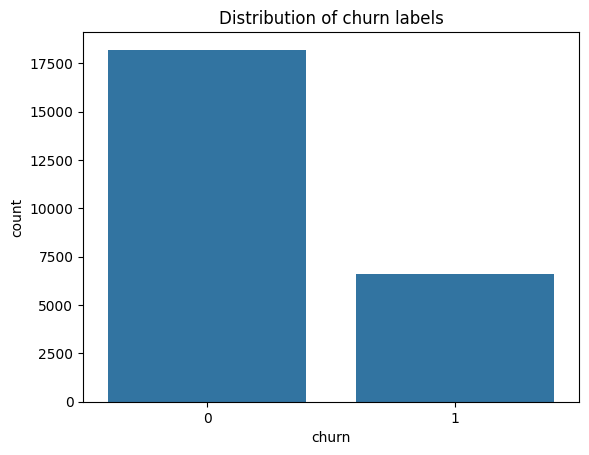

churn
0    0.734345
1    0.265655
Name: proportion, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Target distribution
sns.countplot(x=train_target['churn'])
plt.title('Distribution of churn labels')
plt.show()

# Print ratio
print(train_target['churn'].value_counts(normalize=True))


## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

# Separate features and target from the full dataset
X = train_df.drop(columns=['churn'])
y = train_df['churn']

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Original class distribution: ")
print(y_train.value_counts(normalize=True))

# Apply SMOTE ONLY on training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE: ")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# Create resampled dataframe
df_train_resampled = pd.concat(
    [pd.DataFrame(X_train_resampled, columns=X.columns),
     pd.Series(y_train_resampled, name='churn')],
    axis=1
)

print(f"\nOriginal train size: {len(X_train)}")
print(f"After SMOTE train size: {len(X_train_resampled)}")
print(f"Test size (unchanged): {len(X_test)}")

Original class distribution: 
churn
0    0.734352
1    0.265648
Name: proportion, dtype: float64

After SMOTE: 
churn
1    0.5
0    0.5
Name: proportion, dtype: float64

Original train size: 19827
After SMOTE train size: 29120
Test size (unchanged): 4957


## PCA + SMOTE

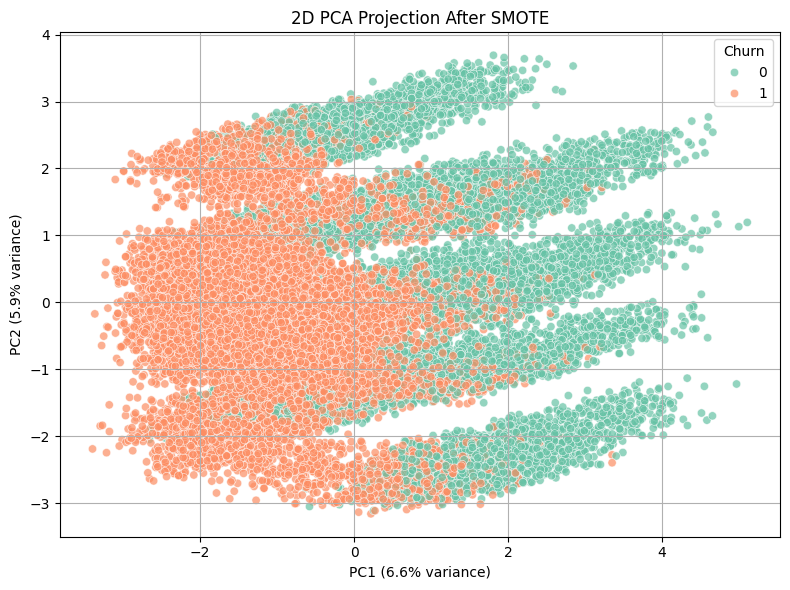

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Step 1: Split FIRST
X = train_df.drop(columns=['churn'])
y = train_df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: SMOTE only on train
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Standardize and PCA (fit only on train)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Plot
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'churn': y_resampled
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='churn', palette='Set2', alpha=0.7)

explained_var = pca.explained_variance_ratio_ * 100
plt.xlabel(f'PC1 ({explained_var[0]:.1f}% variance)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f}% variance)')
plt.title('2D PCA Projection After SMOTE')
plt.grid(True)
plt.legend(title='Churn')
plt.tight_layout()
plt.show()

# 5. Modeling

In [ ]:
!pip install tqdm_joblib

## 5.1.1 Logistic Regression



### Base Logisitic Regression


Classification Report
              precision    recall  f1-score   support

           0      0.989     0.800     0.884     18200
           1      0.638     0.976     0.772      6584

    accuracy                          0.847     24784
   macro avg      0.814     0.888     0.828     24784
weighted avg      0.896     0.847     0.855     24784



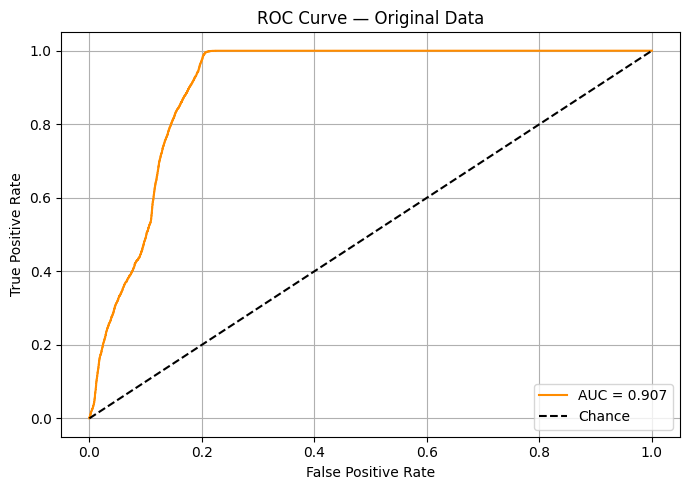

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

# Define features and target
X = train_df.drop(columns=['churn'])
y = train_df['churn']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Simple logistic regression (no hyperparameter search)
model = LogisticRegression(
    class_weight='balanced',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

# Cross-validated predictions & probabilities (10-fold)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_pred_lr = cross_val_predict(model, X_scaled, y, cv=cv, n_jobs=-1)
y_proba_lr = cross_val_predict(
    model, X_scaled, y, cv=cv,
    method='predict_proba', n_jobs=-1
)[:, 1]

# Classification report
print("\nClassification Report")
print(classification_report(y, y_pred_lr, digits=3))

# ROC + AUC
fpr_lr, tpr_lr, _ = roc_curve(y, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(7, 5))
plt.plot(fpr_lr, tpr_lr, label=f'AUC = {roc_auc_lr:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title('ROC Curve — Original Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!pip install tqdm_joblib

### With SMOTE and Hyperparameters_Tuning

GridSearch progress:   0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

Fitting 5 folds for each of 64 candidates, totalling 320 fits
                                               params  mean_test_score
0   {'clf__C': 0.01, 'clf__class_weight': 'balance...         0.846169
4   {'clf__C': 0.01, 'clf__class_weight': 'balance...         0.846169
12  {'clf__C': 0.01, 'clf__class_weight': 'balance...         0.846169
8   {'clf__C': 0.01, 'clf__class_weight': 'balance...         0.846169
9   {'clf__C': 0.01, 'clf__class_weight': 'balance...         0.845867
13  {'clf__C': 0.01, 'clf__class_weight': 'balance...         0.845867
5   {'clf__C': 0.01, 'clf__class_weight': 'balance...         0.845867
1   {'clf__C': 0.01, 'clf__class_weight': 'balance...         0.845867
14  {'clf__C': 0.01, 'clf__class_weight': 'balance...         0.844505
10  {'clf__C': 0.01, 'clf__class_weight': 'balance...         0.844505

Classification Report (Validation):
              precision    recall  f1-score   support

           0      0.989     0.804     0.887      3640
           

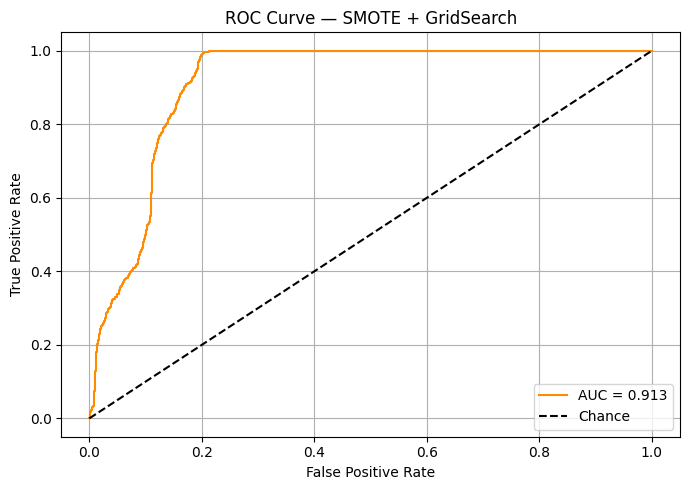

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib
from sklearn.model_selection import ParameterGrid

# Build pipeline: scale → SMOTE → logistic regression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),            # scale features
    ('smote',  SMOTE(random_state=42)),      # balance classes inside CV
    ('clf',    LogisticRegression())         # logistic classifier
])

# Define hyperparameter grid
param_grid = {
    'clf__C':            [0.01, 0.1, 1, 10],
    'clf__penalty':      ['l1', 'l2'],
    'clf__solver':       ['liblinear', 'saga'],
    'clf__class_weight': ['balanced'],
    'clf__max_iter':     [100, 200, 500, 1000]
}

# GridSearchCV with 5-fold stratified CV
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=pipeline_lr,
    param_grid=param_grid,
    scoring='accuracy',
    cv=inner_cv,
    n_jobs=-1,
    verbose=1
)

# set up progress bar
total_fits = len(list(ParameterGrid(param_grid))) * inner_cv.get_n_splits()
with tqdm_joblib(tqdm(desc="GridSearch progress", total=total_fits)):
    grid.fit(X_train, y_train)

# output best model and score
logistic_smote_grid_model = grid.best_estimator_
results_df = pd.DataFrame(grid.cv_results_)[
    ['params','mean_test_score']
].sort_values('mean_test_score', ascending=False)
print(results_df.head(10))

# Final evaluation on validation set
y_pred_lr  = logistic_smote_grid_model.predict(X_test)
y_proba_lr = logistic_smote_grid_model.predict_proba(X_test)[:, 1]

print("\nClassification Report (Validation):")
print(classification_report(y_test, y_pred_lr, digits=3))

# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f'AUC = {roc_auc_lr:.3f}', color='darkorange')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.title('ROC Curve — SMOTE + GridSearch')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.1.2 Random forest


### Baseline Random forest


Random Forest — Classification Report
              precision    recall  f1-score   support

           0      0.906     0.893     0.899     18200
           1      0.716     0.743     0.729      6584

    accuracy                          0.853     24784
   macro avg      0.811     0.818     0.814     24784
weighted avg      0.855     0.853     0.854     24784



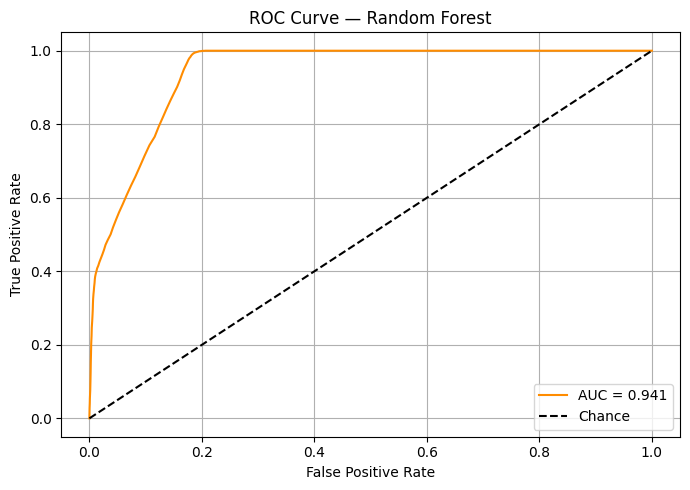

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict

# Define features + target
X = train_df.drop(columns=['churn'])
y = train_df['churn']

# Instantiate a simple Random Forest
rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_estimators=100
)

# 10-fold CV predictions
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_pred_rf  = cross_val_predict(rf, X, y, cv=cv, n_jobs=-1)
y_proba_rf = cross_val_predict(
    rf, X, y, cv=cv, method='predict_proba', n_jobs=-1
)[:, 1]

# Classification report
print("\nRandom Forest — Classification Report")
print(classification_report(y, y_pred_rf, digits=3))

# ROC + AUC
fpr_rf, tpr_rf, _ = roc_curve(y, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7, 5))
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {roc_auc_rf:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title('ROC Curve — Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### With SMOTE and Hyperparameters_Tuning



### RandomizedSearchCV

Tuning hyperparameters:   0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[{'rf__n_estimators': 100, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 5, 'rf__max_features': 0.5, 'rf__max_depth': 1}, {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 5, 'rf__max_features': 0.3, 'rf__max_depth': 10}, {'rf__n_estimators': 100, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 2, 'rf__max_features': 'log2', 'rf__max_depth': 10}, {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_features': 'log2', 'rf__max_depth': 1}, {'rf__n_estimators': 100, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_features': 0.5, 'rf__max_depth': 10}, {'rf__n_estimators': 100, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 30}, {'rf__n_estimators': 300, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 10, 'rf__max_features': 0.5, 'rf__max_depth': 50}, {'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 5, 'rf__max_fea

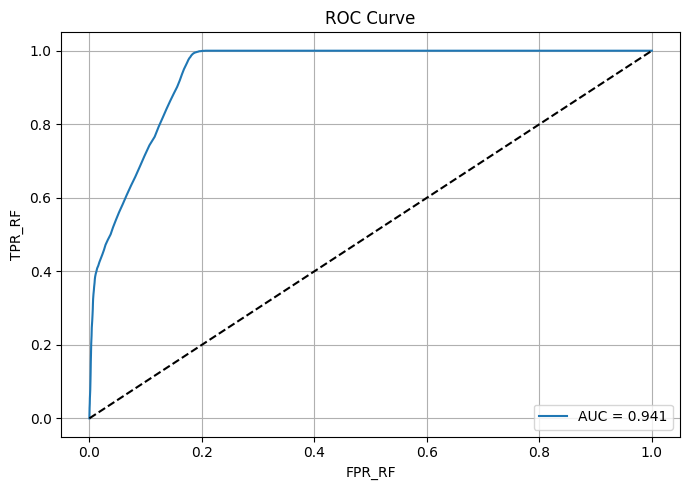

In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_predict
from tqdm_joblib import tqdm_joblib

# pipeline: SMOTE → Random Forest
pipeline_rrf = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
])

# outer CV for performance estimation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# parameter distributions for random search
param_dist = {
    'rf__n_estimators': [100, 200, 300, 500],
    'rf__max_depth': [1, 5, 10, 20, 30, 50],
    'rf__max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 5, 10]
}

# randomized search with inner CV
random_search = RandomizedSearchCV(
    estimator=pipeline_rrf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Compute total fit
inner_cv = random_search.cv
total_fits = random_search.n_iter * inner_cv.get_n_splits(X, y)

# Run the hyperparameter search with a tqdm joblib progress bar
with tqdm_joblib(tqdm(desc="Tuning hyperparameters", total=total_fits)):
      random_search.fit(X_train_resampled, y_train_resampled)

print(random_search.cv_results_['params'])

# Extract the best model and classification_report
best_model = random_search.best_estimator_
y_pred_rf = best_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# ROC AUC plot
fpr_rf, tpr_rf, _ = roc_curve(y, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(7, 5))
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {roc_auc_rf:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR_RF')
plt.ylabel('TPR_RF')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### GridSearchCV

GridSearch progress:   0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

Fitting 5 folds for each of 72 candidates, totalling 360 fits
All tested params: [{'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}, {'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}, {'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}, {'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}, {'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}, {'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}, {'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}, {'rf__

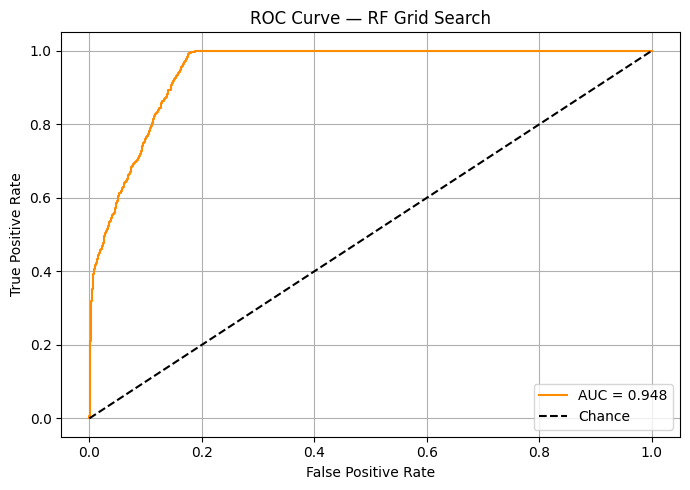

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib

# pipeline: SMOTE → Random Forest
pipeline_rrf = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

# outer CV for later evaluation (if needed)
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Grid of exactly two options per hyperparameter
param_grid = {
    'rf__n_estimators':       [100, 200],
    'rf__max_depth':          [5, 10],
    'rf__max_features':       ['sqrt', 0.3, 0.5],
    'rf__min_samples_split':  [2, 5, 10],
    'rf__min_samples_leaf':   [1, 5]
}

# inner CV for tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=pipeline_rrf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=inner_cv,
    n_jobs=-1,
    verbose=1
)

# compute total number of fits
total_fits = len(list(ParameterGrid(param_grid))) * inner_cv.get_n_splits(
    X_train_resampled, y_train_resampled
)

# run grid search with progress bar
with tqdm_joblib(tqdm(desc="GridSearch progress", total=total_fits)):
    grid.fit(X_train_resampled, y_train_resampled)

# show all tested parameter sets
print("All tested params:", grid.cv_results_['params'])

# best model
best_model = grid.best_estimator_
print("Best params:", grid.best_params_)

# evaluate on hold-out test set
y_pred_rf  = best_model.predict(X_test)
y_proba_rf = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report (TEST):")
print(classification_report(y_test, y_pred_rf, digits=3))

# ROC AUC plot
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7, 5))
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {roc_auc_rf:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — RF Grid Search')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## 5.1.3 XGBoost

### Baseline model

Cross-validated accuracy (train): 0.902 ± 0.006


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:23:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0      0.924     0.887     0.905      3640
           1      0.719     0.798     0.757      1317

    accuracy                          0.864      4957
   macro avg      0.822     0.843     0.831      4957
weighted avg      0.870     0.864     0.866      4957



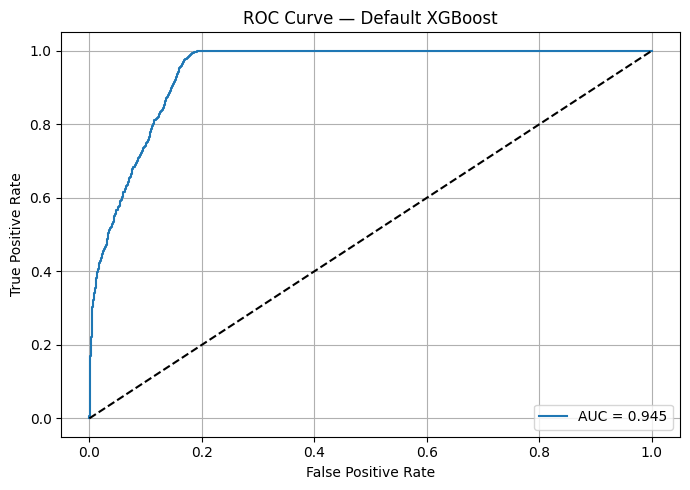

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# pipeline: SMOTE → default XGBoost
pipeline_xgb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(
        use_label_encoder=False,   # disable legacy label encoder
        eval_metric='logloss',     # default eval metric for binary classification
        random_state=42            # ensure reproducibility
    ))
])

# Compute cross validated accuracy on the SMOTE-resampled train set
cv_scores = cross_val_score(
    pipeline_xgb,
    X_train_resampled,
    y_train_resampled,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
print(f"Cross-validated accuracy (train): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Hold-out evaluation on the resampled train
pipeline_xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb  = pipeline_xgb.predict(X_test)
y_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb, digits=3))

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(7, 5))
plt.plot(fpr_xgb, tpr_xgb, label=f'AUC = {roc_auc_xgb:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Default XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


### XGBoost with Hyperparameters tuning and SMOTE



Random search progress:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'xgb__subsample': 0.6, 'xgb__n_estimators': 200, 'xgb__min_child_weight': 5, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.8}
              precision    recall  f1-score   support

           0      0.974     0.843     0.904      3640
           1      0.683     0.937     0.790      1317

    accuracy                          0.868      4957
   macro avg      0.828     0.890     0.847      4957
weighted avg      0.897     0.868     0.873      4957



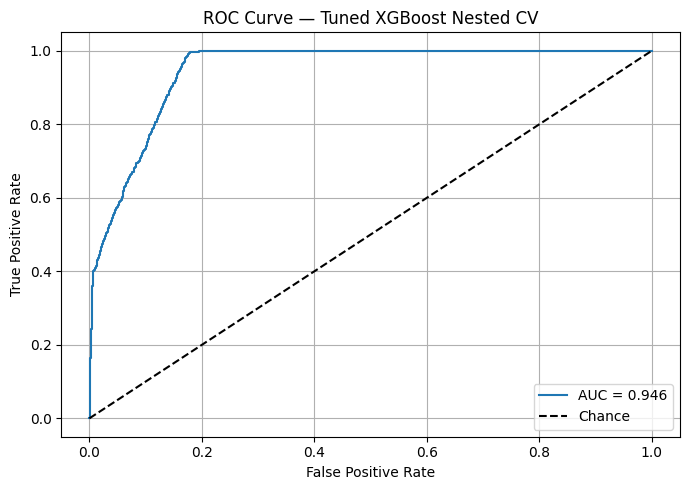

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import numpy as np

# Build pipeline: SMOTE → XGBoost
pipeline_xgb = Pipeline([
    ('smote', SMOTE(random_state=42)),             # oversample minority in each fold
    ('xgb', XGBClassifier(
        use_label_encoder=False,                   # avoid legacy label encoder
        eval_metric='logloss',                     # default binary logloss
        random_state=42,                           # reproducible splits & trees
        n_jobs=-1                                  # parallelize over cores
    ))
])

# Define hyperparameter search space for RandomizedSearchCV
param_dist = {
    'xgb__n_estimators'      : [100, 200, 300, 500],     # number of boosting rounds
    'xgb__max_depth'         : [3, 5, 7, 10],            # max tree depth
    'xgb__learning_rate'     : [0.01, 0.05, 0.1, 0.2],   # shrinkage factor
    'xgb__subsample'         : [0.6, 0.8, 1.0],          # row sampling per tree
    'xgb__colsample_bytree'  : [0.6, 0.8, 1.0],          # feature sampling per tree
    'xgb__min_child_weight'  : [1, 3, 5],               # min sum of instance weight
    'xgb__gamma'             : [0, 1, 5]                # min loss reduction for split
}

# 10-fold CV splitter
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Progress bar around .fit()
total_fits = random_search.n_iter * cv.get_n_splits(X_train_resampled, y_train_resampled)
with tqdm_joblib(tqdm(desc="Random search progress", total=total_fits)):
      random_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters:", random_search.best_params_)

# Take the best pipeline
best_model_xgb = random_search.best_estimator_

# now you can predict as before:
y_pred_xgb  = best_model_xgb.predict(X_test)
y_proba_xgb = best_model_xgb.predict_proba(X_test)[:, 1]

# Report performance across all folds
print(classification_report(y_test, y_pred_xgb, digits=3))

# Plot ROC + AUC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(7, 5))
plt.plot(fpr_xgb, tpr_xgb, label=f'AUC = {roc_auc_xgb:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Tuned XGBoost Nested CV')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Compared between models

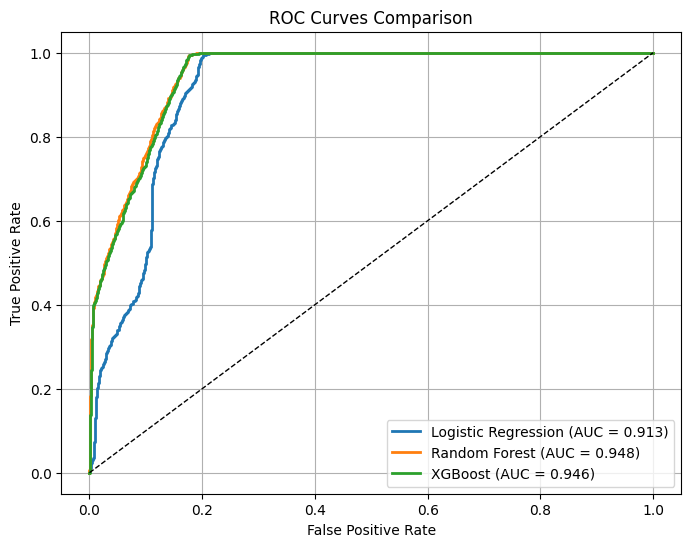

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})', lw=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})', lw=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

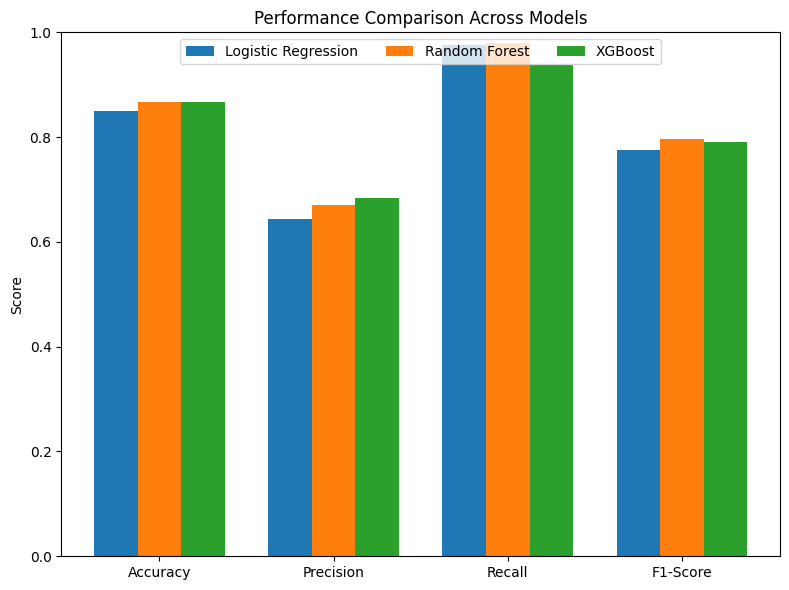

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Derive predicted labels using a 0.5 threshold
y_pred_lr  = (y_proba_lr  >= 0.5).astype(int)
y_pred_rf  = (y_proba_rf  >= 0.5).astype(int)
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

# Define metrics and models
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
models  = ['Logistic Regression', 'Random Forest', 'XGBoost']

scores = {
    'Logistic Regression': [
        accuracy_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_lr)
    ],
    'Random Forest': [
        accuracy_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf)
    ],
    'XGBoost': [
        accuracy_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_xgb)
    ]
}

# Plot grouped bar chart
x     = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))
for i, model in enumerate(models):
    ax.bar(x + i*width, scores[model], width, label=model)

# Formatting
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Performance Comparison Across Models')
ax.legend(loc='upper center', ncol=3)
plt.tight_layout()
plt.show()


## T-test

In [ ]:
from scipy.stats import ttest_rel

models = {
    'Logistic Regression': logistic_smote_grid_model,
    'Random Forest'      : pipeline_rrf,
    'XGBoost'            : best_model_xgb
}

# 1) Perform stratified 10-fold CV and collect per-fold accuracy
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = {name: [] for name in models}

for train_idx, test_idx in outer_cv.split(X, y):
    X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
    X_te, y_te = X.iloc[test_idx],  y.iloc[test_idx]
    for name, mdl in models.items():
        mdl.fit(X_tr, y_tr)
        y_pred = mdl.predict(X_te)
        scores[name].append(accuracy_score(y_te, y_pred))

# 2) Perform paired t-tests between each pair of models
model_names = list(models)
results = []
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        a, b = model_names[i], model_names[j]
        t_stat, p_val = ttest_rel(scores[a], scores[b])
        results.append((a, b, t_stat, p_val))

means = { name: np.mean(scores[name]) for name in scores }

# 3) Display results with direction
alpha = 0.05
print("Paired t-test results (accuracy):")
print(f" {'Model A':<20} {'Model B':<20} {'t-stat':>8} {'p-value':>10} {'Signif.':>10} {'Leader':>20}")
for a, b, t_stat, p_val in results:
    signif = 'Yes' if p_val < alpha else 'No'
    # determine direction if significant
    if signif == 'Yes':
        if means[b] > means[a]:
            leader = f"{b} > {a}"
        else:
            leader = f"{a} > {b}"
    else:
        leader = 'No significant diff'
    print(f"{a:<20} {b:<20} {t_stat:8.3f} {p_val:10.3f} {signif:>10} {leader:>20}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:34:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:34:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:34:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:34:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:34:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Paired t-test results (accuracy):
 Model A              Model B                t-stat    p-value    Signif.               Leader
Logistic Regression  Random Forest          -6.555      0.000        Yes Random Forest > Logistic Regression
Logistic Regression  XGBoost               -10.515      0.000        Yes XGBoost > Logistic Regression
Random Forest        XGBoost                -4.715      0.001        Yes XGBoost > Random Forest


In [ ]:
import pandas as pd

# Predict class only (0 or 1)
y_test_pred = best_model_xgb.predict(test_df)

results_df = pd.DataFrame({
    'prediction': y_test_pred
})

results_df.to_csv('XGBoost_predictions.csv', index=False)


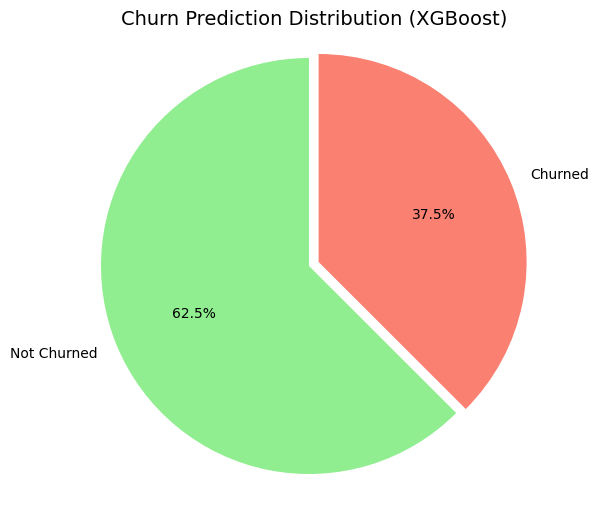

In [ ]:
import matplotlib.pyplot as plt

# Count the predicted labels
labels = ['Not Churned', 'Churned']
sizes = results_df['prediction'].value_counts().sort_index()  # 0 = Not Churned, 1 = Churned
colors = ['lightgreen', 'salmon']

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0, 0.05)
)
plt.title('Churn Prediction Distribution (XGBoost)', fontsize=14)
plt.axis('equal')  # Ensure the pie chart is circular
plt.show()


In [ ]:
from google.colab import files
files.download("XGBoost_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>